In [26]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score

# SVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# GBM
from sklearn.ensemble import GradientBoostingRegressor

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.graphics.regressionplots import influence_plot

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score


import tabulate as tabulate

from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

Text(0, 0.5, 'Count')

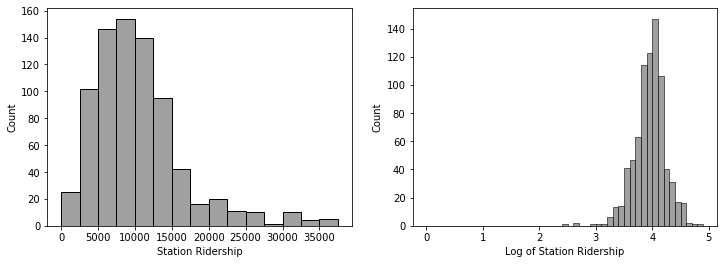

In [2]:
# Load trip data
trips = pd.read_csv("ALL_OSM_Rat4.csv")

# Remove Riverside Museum station
#trips = trips.drop(15)

# Log transform ridership
trips['logcount'] = np.log10(trips['counts'])

# Histograms of ridership
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(data=trips, x='counts', bins=np.arange(0, 40000, 2500), color='grey', edgecolor='black')
plt.xlabel("Station Ridership")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.histplot(data=trips, x='logcount', bins=np.arange(0, 5, 0.1), color='grey', edgecolor='black')
plt.xlabel("Log of Station Ridership")
plt.ylabel("Count")

In [3]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788 entries, 0 to 787
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FID            788 non-null    int64  
 1   EndStationID   788 non-null    int64  
 2   BUS_DIST       788 non-null    float64
 3   METRO_DIST     788 non-null    float64
 4   RAIL_DIST      788 non-null    float64
 5   CAZ_DIST       788 non-null    float64
 6   RetailCoverS   788 non-null    float64
 7   RetailRatio    788 non-null    float64
 8   ResCoverS      788 non-null    float64
 9   ResidentRatio  788 non-null    float64
 10  ParkCoverS     788 non-null    float64
 11  ParkRatio      788 non-null    float64
 12  CommerCoverS   788 non-null    float64
 13  CommerRatio    788 non-null    float64
 14  MetroCommu     680 non-null    float64
 15  BusCommute     680 non-null    float64
 16  Deprivatio     680 non-null    float64
 17  AllusualRe     680 non-null    float64
 18  JobDensity

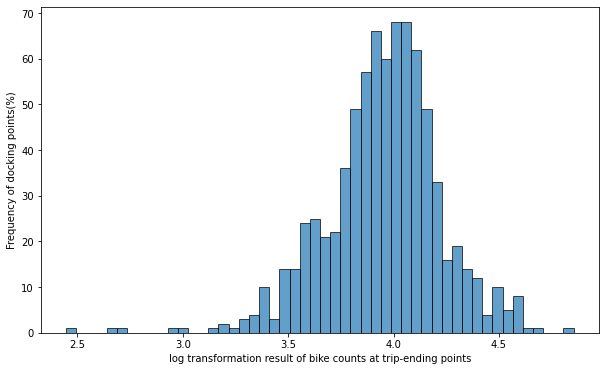

In [31]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

plt.hist(trips['logcount'], bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('log transformation result of bike counts at trip-ending points')
plt.ylabel('Frequency of docking points(%)')

# save the img
# plt.savefig('logcount_histogram.jpg', dpi=150, bbox_inches='tight')
# print("saved as'logcount_histogram.jpg'")

plt.show()

Due to unavalability of 2021 London census data of some LSOA areas, the correspoding row of bike trip ending station has null value as well. However, distance relevant variables are still complete for following analysing. So Stations with null value would be imputed rather than removed from this analysis.

In [34]:
# 创建 SimpleImputer 对象
imputer = SimpleImputer(strategy='most_frequent') 

#拟合模型并进行插补
data_imputed = imputer.fit_transform(trips)

#将结果转回 DataFrame格式
trips = pd.DataFrame(data_imputed, columns=trips.columns, index=trips.index)
trips.describe()

/opt/conda/lib/python3.10/site-packages/sklearn/impute/_base.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


,FID,EndStationID,BUS_DIST,METRO_DIST,RAIL_DIST,CAZ_DIST,RetailCoverS,RetailRatio,ResCoverS,ResidentRatio,...,OfficeWork,MetroCommu.1,BusCommute.1,CarorVanCo,CycleCommu,RoadDen,POPDEN,counts,count_ratio,logcount
count,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,...,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000
mean,393.500000,420.932741,0.174686,0.299308,370.454646,0.426527,0.197652,0.197652,0.359283,0.359283,...,0.229850,0.220268,0.129873,0.127738,0.090913,0.076017,0.010798,10739.455584,0.001269,3.950610
std,227.620298,245.870394,0.179268,0.211568,225.940603,0.234574,0.193669,0.193669,0.221908,0.221908,...,0.041013,0.058718,0.068710,0.057320,0.035231,0.200708,0.007848,7083.767214,0.000837,0.274151
min,0.000000,1.000000,0.000000,0.000000,4.082762,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.133794,0.080808,0.019608,0.039427,0.018265,0.000000,0.000973,280.000000,0.000033,2.447158
25%,196.750000,206.750000,0.054735,0.134303,201.236818,0.235460,0.056796,0.056796,0.163554,0.163554,...,0.206172,0.179625,0.069444,0.080357,0.058333,0.015736,0.004145,6477.750000,0.000765,3.811424
50%,393.500000,427.500000,0.113826,0.252428,342.571413,0.399058,0.142941,0.142941,0.390226,0.390226,...,0.223187,0.219130,0.112200,0.133612,0.088774,0.030733,0.010488,9273.500000,0.001096,3.967244
75%,590.250000,633.250000,0.229574,0.416888,503.275422,0.598202,0.263285,0.263285,0.542442,0.542442,...,0.255999,0.244444,0.172365,0.169715,0.112676,0.057119,0.016009,12962.000000,0.001532,4.112672
max,787.000000,850.000000,1.000000,1.000000,1195.401746,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.393357,0.456193,0.412186,0.301954,0.227811,2.944029,0.048372,71395.000000,0.008436,4.853668


In [9]:
'''
# 使用describe()函数获取描述性统计信息
describe_stats = trips.describe()

# 选择要保留的列
rows_to_keep = ['mean', 'min', 'max', 'std']

# 从describe_stats中提取所需的列
selected_stats = describe_stats.loc[rows_to_keep]

# 将结果保存为CSV文件
selected_stats.to_csv('trip_describe_summary.csv')
'''

In [32]:

# 选择需要标准化的列
columns_to_standardize = ['RetailRatio','CommerRatio', 'ResidentRatio', 'ParkRatio', 'METRO_DIST', 'CAZ_DIST', 'ResCoverS', 'BUS_DIST', 'RetailCoverS', 'ParkCoverS', 'CommerCoverS']

# 创建StandardScaler对象并进行标准化
scaler = MinMaxScaler()
trips[columns_to_standardize] = scaler.fit_transform(trips[columns_to_standardize])


# 输出前几行数据以确认修改已生效
trips.head()

,FID,EndStationID,BUS_DIST,METRO_DIST,RAIL_DIST,CAZ_DIST,RetailCoverS,RetailRatio,ResCoverS,ResidentRatio,...,OfficeWork,MetroCommu.1,BusCommute.1,CarorVanCo,CycleCommu,RoadDen,POPDEN,counts,count_ratio,logcount
0,591,1,0.268152,0.343314,459.626131,0.205535,0.165210,0.165210,0.515733,0.515733,...,0.240000,0.175000,0.158333,0.155556,0.108333,0.006901,0.011312,3758,0.000444,3.574957
1,254,2,0.071575,0.251948,387.149307,0.177583,0.116218,0.116218,0.085651,0.085651,...,0.136395,0.175879,0.075377,0.216080,0.090452,0.013419,0.011180,15333,0.001812,4.185627
2,605,3,0.096885,0.270687,410.602950,0.274569,0.219353,0.219353,0.410694,0.410694,...,0.230155,0.245370,0.097222,0.069444,0.155093,0.011469,0.005276,7665,0.000906,3.884512
3,631,4,0.074240,0.061839,215.292830,0.312585,0.373940,0.373940,0.438245,0.438245,...,0.234731,0.231975,0.172414,0.128527,0.103448,0.004860,0.016783,7055,0.000834,3.848497
4,181,5,0.057739,0.058764,122.144978,0.246289,0.029306,0.029306,0.128732,0.128732,...,0.207200,0.216216,0.081081,0.127413,0.061776,0.005243,0.009730,20532,0.002426,4.312431


### Lasso Regression

In [35]:

# Lasso Regression
# Select columns with 11 independent variables & dependent logcount
#selected_columns = ['BUS_DIST','METRO_DIST','RAIL_DIST','CAZ_DIST','RetailCoverS','ResCoverS','ParkCoverS','CommerCoverS','Deprivatio','OfficeWork','MetroCommu','BusCommute','CycleCommu','NoCar','StudentRat','RoadDen', 'POPDEN', 'logcount']
trips_selection = trips[['BUS_DIST','METRO_DIST','RAIL_DIST','CAZ_DIST','RetailCoverS','ResCoverS','ParkCoverS','CommerCoverS','Deprivatio','OfficeWork','MetroCommu','BusCommute','CycleCommu','NoCar','StudentRat','RoadDen', 'POPDEN', 'logcount']]

# Split into predictor variables (X) and outcome variable (y)
X = trips_selection.drop('logcount', axis=1)
y = trips_selection['logcount']

# Perform Lasso regression with cross-validation to find the best alpha (lambda) value
lasso = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, random_state=123)
lasso.fit(X, y)

# Display the best alpha (lambda) value
best_alpha = lasso.alpha_
print("Best Alpha (Lambda):", best_alpha)

# Train the final Lasso model with the best alpha (lambda) value
lasso_final = LassoCV(alphas=[best_alpha], cv=5, random_state=123)
lasso_final.fit(X, y)

# Display regression coefficients and sort by absolute coefficient value
lasso_coef = pd.DataFrame({'Variable': X.columns, 'Coefficient': lasso_final.coef_})
lasso_coef['Absolute_Coefficient'] = abs(lasso_coef['Coefficient'])
sorted_lasso_coef = lasso_coef.sort_values(by='Absolute_Coefficient', ascending=False)
print(sorted_lasso_coef[['Variable', 'Coefficient']])  

Best Alpha (Lambda): 0.0006428073117284319
        Variable  Coefficient
13         NoCar     0.236741
10    MetroCommu    -0.184004
6     ParkCoverS     0.157026
7   CommerCoverS     0.155881
1     METRO_DIST    -0.150141
8     Deprivatio    -0.100359
9     OfficeWork    -0.078372
0       BUS_DIST    -0.075114
5      ResCoverS    -0.071982
15       RoadDen    -0.064386
11    BusCommute     0.036287
4   RetailCoverS     0.023880
2      RAIL_DIST    -0.000052
3       CAZ_DIST     0.000000
12    CycleCommu     0.000000
14    StudentRat    -0.000000
16        POPDEN    -0.000000


In [134]:
# Export model_stats to an Excel file named "step_model.xlsx"
#lasso_coef.to_excel("lasso_coef.xlsx", index=True)

以上步骤用lasso regression初步筛选出相关系数为0的变量。Distance to Central Activity Zone(CAZ), Student Rate, Cycle to Commute population ratio, population density这些变量被剔除后，其他自变量被加入斯皮尔曼回归分析。<br><br>
The above steps were used in lasso regression to initially screen out variables with a correlation coefficient of zero." Distance to Central Activity Zone(CAZ)", "Cycle to Commute population ratio","Ratio of student residents" and "population density" were eliminated and the remaining independent variables were added to the Spearman regression analysis.

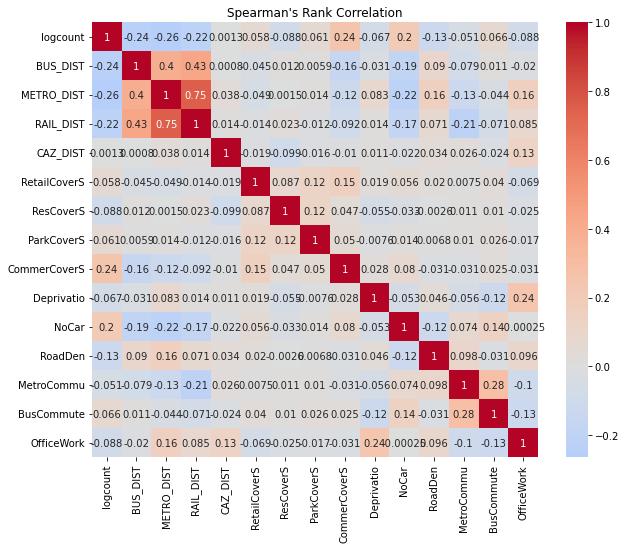

'\n# Calculate Spearman\'s rank correlation\ncorrelation_matrix = trips.corr(method=\'spearman\')\nplt.figure(figsize=(10, 8))\nsns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)\nplt.title("Spearman\'s Rank Correlation")\nplt.show()\n'

In [36]:
# Select the columns of interest
columns_of_interest = ['logcount', 'BUS_DIST', 'METRO_DIST', 'RAIL_DIST', 'CAZ_DIST', 'RetailCoverS',
                       'ResCoverS', 'ParkCoverS', 'CommerCoverS', 'Deprivatio', 'NoCar', 'RoadDen','MetroCommu','BusCommute','OfficeWork']

#columns_of_interest = ['logcount', 'BUS_DIST', 'METRO_DIST', 'RAIL_DIST', 'CAZ_DIST', 'RetailCoverS', 'ResCoverS', 'ParkCoverS', 'CommerCoverS', 'Deprivatio', 'NoCar', 'RoadDen','OfficeWork']

# Calculate Spearman's rank correlation for the selected columns
correlation_matrix = trips[columns_of_interest].corr(method='spearman')

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Spearman's Rank Correlation")
plt.show()

'''
# Calculate Spearman's rank correlation
correlation_matrix = trips.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Spearman's Rank Correlation")
plt.show()
'''

In [ ]:
# Select the columns of interest
columns_of_interest = ['logcount', 'BUS_DIST', 'METRO_DIST', 'RAIL_DIST', 'CAZ_DIST', 'RetailCoverS',
                       'ResCoverS', 'ParkCoverS', 'CommerCoverS', 'Deprivatio', 'NoCar', 'RoadDen','MetroCommu','BusCommute','OfficeWork']

#columns_of_interest = ['logcount', 'BUS_DIST', 'METRO_DIST', 'RAIL_DIST', 'CAZ_DIST', 'RetailCoverS', 'ResCoverS', 'ParkCoverS', 'CommerCoverS', 'Deprivatio', 'NoCar', 'RoadDen','OfficeWork']

# Calculate Spearman's rank correlation for the selected columns
correlation_matrix = trips[columns_of_interest].corr(method='spearman')

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Spearman's Rank Correlation")
plt.show()

'''
# Calculate Spearman's rank correlation
correlation_matrix = trips.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Spearman's Rank Correlation")
plt.show()
'''

In [37]:
# Check multicollinearity
trips1 = trips[[ 'BUS_DIST', 'METRO_DIST', 'RAIL_DIST', 'CAZ_DIST', 'RetailCoverS',
                       'ResCoverS', 'ParkCoverS', 'CommerCoverS', 'Deprivatio', 'NoCar', 'RoadDen','MetroCommu','BusCommute','OfficeWork']]
vif = pd.DataFrame()
vif["Features"] = trips1.columns
vif["VIF Factor"] = [variance_inflation_factor(trips1.values, i) for i in range(trips1.shape[1])]
print(vif)

        Features  VIF Factor
0       BUS_DIST    2.878198
1     METRO_DIST    6.114415
2      RAIL_DIST    8.128882
3       CAZ_DIST    4.422610
4   RetailCoverS    2.103848
5      ResCoverS    3.561258
6     ParkCoverS    1.579841
7   CommerCoverS    1.348382
8     Deprivatio    4.797578
9          NoCar   25.650213
10       RoadDen    1.175398
11    MetroCommu   10.261343
12    BusCommute    3.524197
13    OfficeWork   31.089381


By analyzing the VIF values for the remaining variables, "Distance to railway station" variable was observed a high VIF value of 7.497, attributed to the fact that it has a high correlation with  "Distance to metro station" (0.75). Therefore,  "Distance to railway station" was removed from the final lasso regression model. Also, "Metro-commute population ratio" variable was observed a high VIF value of 10.26, correlated with "Bus commute population ratio" (0.28), so MetroCommu was removed as well.
<br><br>OfficeWork, NoCar, MetroCommu all have higher than 10 VIF score, so they will be removed too. 

In [4]:
columns_to_keep = ['logcount', 'BUS_DIST','CAZ_DIST','RetailCoverS','ResCoverS','ParkCoverS','CommerCoverS','Deprivatio','RoadDen']

#trips1 = trips.loc[:, columns_to_keep]
trips1 = trips[columns_to_keep].copy()

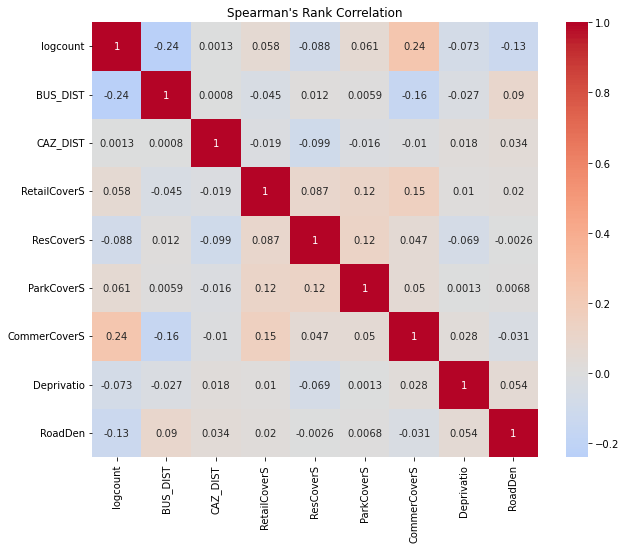

In [5]:
# Check Spearman's rank correlation again
correlation_matrix = trips1.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Spearman's Rank Correlation")
plt.savefig('Spearman Rank Correlation.jpg')
plt.show()

In [ ]:
# 假设的数据集

X = trips2.drop(columns=['logcount','FID','EndStationID','count_ratio','counts','AllusualRe','Deprivatio.1','MetroCommu.1','BusCommute.1','OfficeWork','CycleCommu','StudentRat', 'POPDEN'])
X = sm.add_constant(X)
y = trips2['logcount']
})
# 计算Spearman秩相关系数
spearman_corr =  trips1.corr(method='spearman'), method='spearman')
print(f"Spearman rank correlation coefficient: {spearman_corr}")
# 进行Spearman回归分析
X = data['x'].values.reshape(-1, 1)
Y = data['y'].values.reshape(-1, 1)
X_train = X[:-10]
Y_train = Y[:-10]
X_test = X[10:]
Y_test = Y[10:]
# 添加常数项以拟合截距
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
# 拟合模型
model = sm.OLS(Y_train, X_train).fit()
# 打印回归结果摘要
print(model.summary())
# 创建箱型图
plt.figure(figsize=(10, 6))
plt.boxplot([data['x'], data['y']], vert=False, labels=['x', 'y'])
plt.title('Box Plot of Genezi Metric')
plt.show()

In [43]:
# Check multicollinearity again
X_selected = trips1[['BUS_DIST','CAZ_DIST','RetailCoverS','ResCoverS','ParkCoverS','CommerCoverS','Deprivatio','RoadDen']]
vif = pd.DataFrame()
vif["Features"] = X_selected.columns
vif["VIF Factor"] = [variance_inflation_factor(X_selected.values, i) for i in range(X_selected.shape[1])]
print(vif)

       Features  VIF Factor
0      BUS_DIST    1.820311
1      CAZ_DIST    3.202648
2  RetailCoverS    2.025232
3     ResCoverS    2.772398
4    ParkCoverS    1.544988
5  CommerCoverS    1.298735
6    Deprivatio    3.342715
7       RoadDen    1.170452


In [70]:
## Final OLS 

# Define the independent variables and the dependent variable
X = trips[['BUS_DIST','CAZ_DIST','RetailCoverS','ResCoverS','ParkCoverS','CommerCoverS','Deprivatio','RoadDen']]
y = trips['logcount']

# Add an intercept term
X = sm.add_constant(X)

# Create and fit the linear regression model
lm_all = sm.OLS(y, X).fit()


# Get AIC and BIC
aic_value = lm_all.aic
bic_value = lm_all.bic

# Print AIC and BIC
print(f'AIC: {aic_value}')
print(f'BIC: {bic_value}')


# Create a table of regression results
regression_table = tabulate.tabulate(lm_all.summary().tables[1], headers='keys', tablefmt='pretty')


# Display the regression table
print(regression_table)

AIC: 157.69799123795178
BIC: 199.7234740466727
+--------------+---------+---------+---------+-------+--------+--------+
|      0       |    1    |    2    |    3    |   4   |   5    |   6    |
+--------------+---------+---------+---------+-------+--------+--------+
|              |  coef   | std err |    t    | P>|t| | [0.025 | 0.975] |
|    const     | 4.0603  |  0.036  | 114.138 | 0.000 | 3.990  | 4.130  |
|   BUS_DIST   | -0.2461 |  0.053  | -4.629  | 0.000 | -0.351 | -0.142 |
|   CAZ_DIST   | -0.0071 |  0.041  | -0.174  | 0.862 | -0.087 | 0.073  |
| RetailCoverS | 0.0428  |  0.050  |  0.861  | 0.390 | -0.055 | 0.140  |
|  ResCoverS   | -0.0896 |  0.043  | -2.065  | 0.039 | -0.175 | -0.004 |
|  ParkCoverS  | 0.2213  |  0.088  |  2.505  | 0.012 | 0.048  | 0.395  |
| CommerCoverS | 0.2048  |  0.069  |  2.952  | 0.003 | 0.069  | 0.341  |
|  Deprivatio  | -0.1510 |  0.040  | -3.739  | 0.000 | -0.230 | -0.072 |
|   RoadDen    | -0.0821 |  0.048  | -1.716  | 0.087 | -0.176 | 0.012  |
+---

In [71]:
# Final Lasso
# Train the final Lasso model with the best alpha (lambda) value
lasso_final = LassoCV(alphas=[best_alpha], cv=5, random_state=123)
lasso_final.fit(X, y)

# Display regression coefficients and sort by absolute coefficient value
lasso_coef = pd.DataFrame({'Variable': X.columns, 'Coefficient': lasso_final.coef_})
lasso_coef['Absolute_Coefficient'] = abs(lasso_coef['Coefficient'])
sorted_lasso_coef = lasso_coef.sort_values(by='Absolute_Coefficient', ascending=False)
print(sorted_lasso_coef[['Variable', 'Coefficient']])

# Predict logcount on the entire dataset
y_pred = lasso_final.predict(X)

# Evaluate the model on training data
mse_train = mean_squared_error(y, y_pred)
r2_train = r2_score(y, y_pred)
cv_r2 = cross_val_score(lasso_final, X, y, cv=5, scoring='r2').mean()

# Print additional evaluation metrics
print(f'Mean Squared Error (MSE) on training data: {mse_train}')
print(f'R-squared on training data: {r2_train}')
print(f'Cross-validated R-squared: {cv_r2}')

       Variable  Coefficient
1      BUS_DIST    -0.228323
6  CommerCoverS     0.173802
5    ParkCoverS     0.161655
7    Deprivatio    -0.135729
4     ResCoverS    -0.072944
8       RoadDen    -0.062987
3  RetailCoverS     0.028344
0         const     0.000000
2      CAZ_DIST    -0.000000
Mean Squared Error (MSE) on training data: 0.07002147999875201
R-squared on training data: 0.06717004481639943
Cross-validated R-squared: -0.040099634985531284


In [73]:
# Calculate AIC and BIC manually
n = len(y)  # Number of samples
k = len(lasso_final.coef_.nonzero()[0])  # Number of nonzero coefficients (parameters)
residuals = y - y_pred
rss = np.sum(residuals**2)  # Residual sum of squares

# AIC and BIC formulas
aic_value = n * np.log(rss / n) + 2 * k
bic_value = n * np.log(rss / n) + k * np.log(n)

# Print AIC and BIC
print(f'AIC: {aic_value}')
print(f'BIC: {bic_value}')

AIC: -2081.2551427804688
BIC: -2048.5686561514635


The lasso regression results show that the distance to the nearest bus station (m), nearest metro station (m), the population density and university percentage variables are not significant at the 95% level of confidence. However, ratio of household with no car is significant, while the distance to the nearest metro station ranked second in the p-value performance.

Examining the variables in more detail shows that there is some positive correlation between bike parking counts at docking points and area of leisure park within 500m buffer area, as well as commercial and retail landuse. Besideds, there is some negative correlation between bike parking counts at docking points and road density around the station, also distance to central activity zone centre and deprivation rate of the corresonding LSOA area. However, the strength of the association appears relatively low.

## TRY1:SVM

Mean Squared Error (MSE): 0.07073564744416909
R-squared: -0.030771927377124086


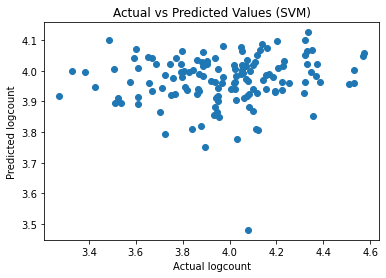

In [2]:

# Your dataset
trips2 = pd.read_csv("ALL_OSM_Rat4.csv")
trips2['logcount'] = np.log10(trips2['counts'])
trips2 = trips2.dropna()

# Define the independent variables and the dependent variable
X = trips2[['BUS_DIST', 'CAZ_DIST', 'RetailCoverS', 'ResCoverS', 'ParkCoverS', 'CommerCoverS', 'Deprivatio', 'RoadDen']]
y = trips2['logcount']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and fit the Support Vector Regression (SVR) model
svm_model = SVR(kernel='linear')  # You can choose other kernels like 'rbf' or 'poly' based on your data
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Print evaluation metrics with explanations
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared: {r_squared}')

# Plot actual vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual logcount')
plt.ylabel('Predicted logcount')
plt.title('Actual vs Predicted Values (SVM)')
plt.show()


## Try GBM Gradient Boosting Machines

Mean Squared Error: 0.05436355209892657


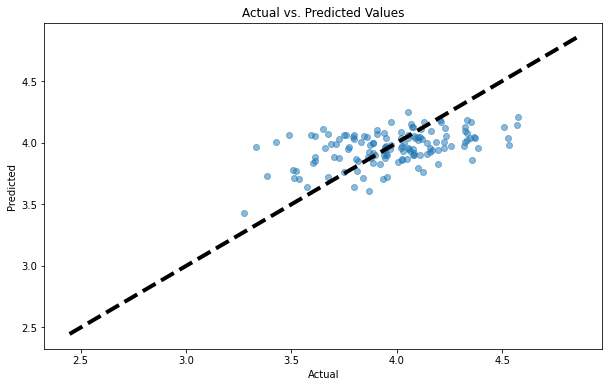

In [11]:
# Create  regression dataset
trips2 = pd.read_csv("ALL_OSM_Rat4.csv")
trips2['logcount'] = np.log10(trips2['counts'])
trips2 = trips2.dropna()

# Define the independent variables and the dependent variable
X = trips2[['BUS_DIST', 'CAZ_DIST', 'RetailCoverS', 'ResCoverS', 'ParkCoverS', 'CommerCoverS', 'Deprivatio', 'RoadDen']]
y = trips2['logcount']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Gradient Boosting Regressor model
gbdt = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
gbdt.fit(X_train, y_train)

# Make predictions
y_pred = gbdt.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()

In [33]:
trips2.describe()

,FID,EndStationID,BUS_DIST,METRO_DIST,RAIL_DIST,CAZ_DIST,RetailCoverS,RetailRatio,ResCoverS,ResidentRatio,...,OfficeWork,MetroCommu.1,BusCommute.1,CarorVanCo,CycleCommu,RoadDen,POPDEN,counts,count_ratio,logcount
count,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,...,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000
mean,391.101471,417.051471,156.791001,422.501293,365.048209,3916.471356,35517.884437,0.010080,268362.149434,0.010341,...,0.230908,0.216428,0.139471,0.140967,0.096087,0.068606,0.012358,10616.385294,0.001254,3.945819
std,224.145433,243.349907,156.377099,300.864693,228.301964,2074.768809,34589.317299,0.009816,162041.746048,0.006244,...,0.044061,0.062358,0.069275,0.050293,0.035256,0.161422,0.007321,7003.688008,0.000828,0.274679
min,0.000000,1.000000,4.644980,4.352491,4.082762,169.372207,0.000000,0.000000,0.000000,0.000000,...,0.133794,0.080808,0.019608,0.039427,0.018265,0.000000,0.000973,280.000000,0.000033,2.447158
25%,195.750000,203.750000,52.726356,186.878154,195.523680,2244.496216,10463.224610,0.002969,130538.982450,0.005030,...,0.200431,0.174815,0.085794,0.107843,0.070651,0.015736,0.006821,6378.750000,0.000754,3.804724
50%,390.500000,420.500000,103.957119,356.462168,333.920028,3629.811318,25711.000000,0.007297,291875.921900,0.011247,...,0.230193,0.208743,0.130326,0.141593,0.093333,0.030433,0.011589,9236.000000,0.001091,3.965484
75%,581.250000,625.250000,204.757796,592.813600,497.629703,5405.163827,47176.700195,0.013389,402404.968750,0.015506,...,0.260762,0.244444,0.180255,0.177558,0.117241,0.057119,0.016859,12856.750000,0.001519,4.109131
max,787.000000,850.000000,881.730394,1404.020820,1195.401746,9017.367554,179076.000000,0.050822,736713.687500,0.028388,...,0.393357,0.456193,0.412186,0.301954,0.227811,2.127245,0.048372,71395.000000,0.008436,4.853668


Mean Squared Error (MSE): 0.05436355209892657
R-squared: 0.2078050403043783
[0.13378508 0.07014074 0.07512814 0.10750795 0.09989652 0.24295478
 0.11717172 0.15341506]


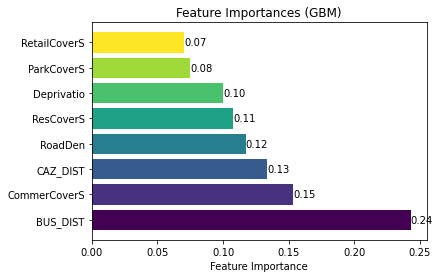

"\n# 绘制特征重要性\nplt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')\nplt.yticks(range(len(sorted_idx)), features)\nplt.xlabel('Feature Importance')\nplt.title('Feature Importances (GBM)')\nplt.show()\n"

In [31]:
# 读取数据集
trips2 = pd.read_csv("ALL_OSM_Rat4.csv")
trips2['logcount'] = np.log10(trips2['counts'])
trips2 = trips2.dropna()
# 定义自变量和因变量
X = trips2[['BUS_DIST', 'CAZ_DIST', 'RetailCoverS', 'ResCoverS', 'ParkCoverS', 'CommerCoverS', 'Deprivatio', 'RoadDen']]
y = trips2['logcount']
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# 创建并拟合GBM模型
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm_model.fit(X_train_scaled, y_train)
# 在测试集上进行预测
y_pred = gbm_model.predict(X_test_scaled)
# 评估模型
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
# 打印评估指标
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared: {r_squared}')
# 获取特征重要性
feature_importances = gbm_model.feature_importances_
print(feature_importances)
# 将特征重要性排序并与特征名称对应
sorted_idx = np.argsort(feature_importances)
features = X.columns[sorted_idx]



# 创建一个颜色数组，其长度与特征重要性数组相同
num_features = len(features)
color_array = plt.cm.viridis(np.linspace(0, 1, num_features))
# 对特征重要性进行排序，并获取逆序索引
sorted_idx = np.argsort(feature_importances)[::-1]
# 使用barh函数绘制柱状图，并设置颜色
plt.barh(range(num_features), feature_importances[sorted_idx], color=color_array)

# 在每个柱子上添加数字
for i, value in enumerate(feature_importances[sorted_idx]):
    plt.text(value, i, f'{value:.2f}', color='black', va='center')
# 设置y轴的刻度标签为特征名称，使用逆序索引
plt.yticks(range(num_features), [features[i] for i in sorted_idx])



# 设置x轴标签
plt.xlabel('Feature Importance')
# 设置图表标题
plt.title('Feature Importances (GBM)')
# 显示图表
plt.show()


'''
# 绘制特征重要性
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features)
plt.xlabel('Feature Importance')
plt.title('Feature Importances (GBM)')
plt.show()
'''

In [35]:
# 假设gbm_model是一个回归模型，X和y是特征和目标变量
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
import numpy as np

# 计算性能指标（适用于回归）
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

# K折交叉验证（适用于回归）
k = 5  # 你选择的K折数
scores = cross_val_score(gbm_model, X, y, cv=k, scoring='neg_mean_squared_error')  # 注意指定评分指标
k_score = np.mean(scores)

# 打印结果
print(f'MAE: {mae}')
print(f'R^2: {r2}')
print(f'MSE: {mse}')
print(f'K-fold CV Score (Neg MSE): {k_score}')


ValueError: Found input variables with inconsistent numbers of samples: [680, 136]

In [29]:
trips2.describe()

,FID,EndStationID,BUS_DIST,METRO_DIST,RAIL_DIST,CAZ_DIST,RetailCoverS,RetailRatio,ResCoverS,ResidentRatio,...,OfficeWork,MetroCommu.1,BusCommute.1,CarorVanCo,CycleCommu,RoadDen,POPDEN,counts,count_ratio,logcount
count,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,...,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000
mean,391.101471,417.051471,156.791001,422.501293,365.048209,3916.471356,35517.884437,0.010080,268362.149434,0.010341,...,0.230908,0.216428,0.139471,0.140967,0.096087,0.068606,0.012358,10616.385294,0.001254,3.945819
std,224.145433,243.349907,156.377099,300.864693,228.301964,2074.768809,34589.317299,0.009816,162041.746048,0.006244,...,0.044061,0.062358,0.069275,0.050293,0.035256,0.161422,0.007321,7003.688008,0.000828,0.274679
min,0.000000,1.000000,4.644980,4.352491,4.082762,169.372207,0.000000,0.000000,0.000000,0.000000,...,0.133794,0.080808,0.019608,0.039427,0.018265,0.000000,0.000973,280.000000,0.000033,2.447158
25%,195.750000,203.750000,52.726356,186.878154,195.523680,2244.496216,10463.224610,0.002969,130538.982450,0.005030,...,0.200431,0.174815,0.085794,0.107843,0.070651,0.015736,0.006821,6378.750000,0.000754,3.804724
50%,390.500000,420.500000,103.957119,356.462168,333.920028,3629.811318,25711.000000,0.007297,291875.921900,0.011247,...,0.230193,0.208743,0.130326,0.141593,0.093333,0.030433,0.011589,9236.000000,0.001091,3.965484
75%,581.250000,625.250000,204.757796,592.813600,497.629703,5405.163827,47176.700195,0.013389,402404.968750,0.015506,...,0.260762,0.244444,0.180255,0.177558,0.117241,0.057119,0.016859,12856.750000,0.001519,4.109131
max,787.000000,850.000000,881.730394,1404.020820,1195.401746,9017.367554,179076.000000,0.050822,736713.687500,0.028388,...,0.393357,0.456193,0.412186,0.301954,0.227811,2.127245,0.048372,71395.000000,0.008436,4.853668


Mean Squared Error (MSE): 0.05436355209892657
R-squared: 0.2078050403043783
[0.13378508 0.07014074 0.07512814 0.10750795 0.09989652 0.24295478
 0.11717172 0.15341506]


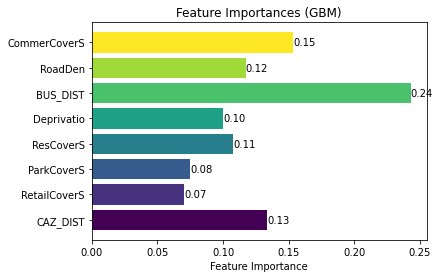

In [14]:
# dataset
trips2 = pd.read_csv("ALL_OSM_Rat4.csv")
trips2['logcount'] = np.log10(trips2['counts'])
trips2 = trips2.dropna()

# Define the independent variables and the dependent variable
X = trips2[['BUS_DIST', 'CAZ_DIST', 'RetailCoverS', 'ResCoverS', 'ParkCoverS', 'CommerCoverS', 'Deprivatio', 'RoadDen']]
y = trips2['logcount']

'''
# 划分数据集
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化特征
 scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
 '''

# 创建并拟合GBM模型
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm_model.fit(X_train_scaled, y_train)

# 在测试集上进行预测
y_pred = gbm_model.predict(X_test_scaled)

# 评估模型
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# 打印评估指标
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared: {r_squared}')

# 获取特征重要性
feature_importances = gbm_model.feature_importances_
print(feature_importances)

# 将特征重要性排序并与特征名称对应
sorted_idx = np.argsort(feature_importances)
features = X.columns[sorted_idx]


'''
# 绘制特征重要性
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features)
plt.xlabel('Feature Importance')
plt.title('Feature Importances (GBM)')
plt.show()
'''


# 创建一个颜色数组，其长度与特征重要性数组相同
num_features = len(features)
color_array = plt.cm.viridis(np.linspace(0, 1, num_features))
# 使用barh函数绘制柱状图，并设置颜色
plt.barh(range(num_features), feature_importances, color=color_array)
# 在每个柱子上添加数字
for i, value in enumerate(feature_importances):
    plt.text(value, i, f'{value:.2f}', color='black', va='center')
# 设置y轴的刻度标签为特征名称
plt.yticks(range(num_features), features)
# 设置x轴标签
plt.xlabel('Feature Importance')
# 设置图表标题
plt.title('Feature Importances (GBM)')
# 调整子图之间的间距
plt.subplots_adjust(hspace=0.5)
# 显示图表
plt.show()

## GBDT model

Mean Squared Error (MSE): 0.1083987763897307
R-squared: -0.5796054705338691
[0.14763606 0.06729475 0.09098963 0.13458603 0.09935846 0.20108686
 0.16790706 0.09114116]


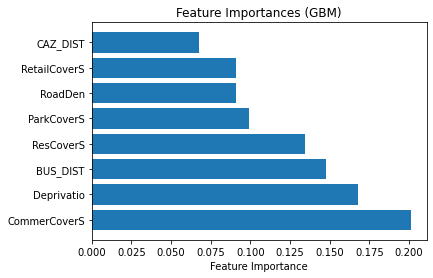

"\n# 创建一个颜色数组，其长度与特征重要性数组相同\nnum_features = len(features)\ncolor_array = plt.cm.viridis(np.linspace(0, 1, num_features))\n\n\n# 使用barh函数绘制柱状图，并设置颜色\nplt.barh(range(num_features), feature_importances[sorted_idx], color=color_array)\n\n# 在每个柱子上添加数字\nfor i, value in enumerate(feature_importances[sorted_idx]):\n    plt.text(value, i, f'{value:.2f}', color='black', va='center')\n\n# 设置y轴的刻度标签为特征名称，使用逆序索引\nplt.yticks(range(num_features), [features[i] for i in sorted_idx])\n\n# 设置x轴标签\nplt.xlabel('Feature Importance')\n# 设置图表标题\nplt.title('Feature Importances (GBDT)')\n# 显示图表\nplt.show()\n"

In [25]:

# 读取数据集
trips2 = pd.read_csv("ALL_OSM_Rat4.csv")
trips2['logcount'] = np.log10(trips2['counts'])
trips2 = trips2.dropna()

# 定义自变量和因变量
X = trips2[['BUS_DIST', 'CAZ_DIST', 'RetailCoverS', 'ResCoverS', 'ParkCoverS', 'CommerCoverS', 'Deprivatio', 'RoadDen']]
y = trips2['logcount']

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 创建并拟合GBDT模型
gbdt_model = DecisionTreeRegressor(random_state=42)
gbdt_model.fit(X_train_scaled, y_train)

# 在测试集上进行预测
y_pred = gbdt_model.predict(X_test_scaled)

# 评估模型
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# 打印评估指标
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared: {r_squared}')

# 获取特征重要性
feature_importances = gbdt_model.feature_importances_
print(feature_importances)

# 将特征重要性排序并与特征名称对应
sorted_idx = np.argsort(feature_importances)[::-1]
features = X.columns[sorted_idx]

# 绘制特征重要性
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features)
plt.xlabel('Feature Importance')
plt.title('Feature Importances (GBM)')
plt.show()


'''
# 创建一个颜色数组，其长度与特征重要性数组相同
num_features = len(features)
color_array = plt.cm.viridis(np.linspace(0, 1, num_features))


# 使用barh函数绘制柱状图，并设置颜色
plt.barh(range(num_features), feature_importances[sorted_idx], color=color_array)

# 在每个柱子上添加数字
for i, value in enumerate(feature_importances[sorted_idx]):
    plt.text(value, i, f'{value:.2f}', color='black', va='center')

# 设置y轴的刻度标签为特征名称，使用逆序索引
plt.yticks(range(num_features), [features[i] for i in sorted_idx])

# 设置x轴标签
plt.xlabel('Feature Importance')
# 设置图表标题
plt.title('Feature Importances (GBDT)')
# 显示图表
plt.show()
'''


In [3]:
# Print SVR model parameters
print(f'SVR Model Parameters: {svm_model.get_params()}')

# Print the number of support vectors
print(f'Number of Support Vectors: {svm_model.n_support_}')

# Perform cross-validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=5)
print(f'Cross-validation Scores (5 folds): {scores}')
print(f'Mean Cross-validation Score: {np.mean(scores)}')

# Print the decision function of the SVR model
print(f'Support Vectors Indices: {svm_model.support_}')
print(f'Support Vectors Coefficients: {svm_model.coef_}')

# Print prediction probabilities
y_pred_prob = svm_model.predict_proba(X_test_scaled)[:, 1]
print(f'Prediction Probabilities: {y_pred_prob}')

# Print time performance
import time
start_time = time.time()
y_pred = svm_model.predict(X_test_scaled)
train_time = time.time() - start_time
print(f'Training Time: {train_time}')
start_time = time.time()
y_pred = svm_model.predict(X_test_scaled)
pred_time = time.time() - start_time
print(f'Prediction Time: {pred_time}')


SVR Model Parameters: {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Number of Support Vectors: [358]
Cross-validation Scores (5 folds): [ 0.09088119 -0.00915493  0.06584324  0.00955192  0.17829355]
Mean Cross-validation Score: 0.06708299143396153
Support Vectors Indices: [  0   1   2   3   4   5   7  11  15  16  18  20  22  23  25  26  27  28
  30  31  32  35  37  38  40  41  43  44  48  53  54  55  56  57  58  59
  60  63  64  65  66  67  68  69  70  71  72  76  77  78  79  80  81  82
  83  84  85  92  94  95  97  99 100 101 104 107 108 110 111 112 113 116
 117 118 119 121 122 123 124 128 129 130 131 134 137 138 139 141 143 144
 146 147 148 149 150 151 152 153 154 155 156 157 158 160 161 163 165 166
 168 169 171 172 173 174 177 178 179 180 181 184 186 187 188 189 194 195
 196 198 199 200 201 204 205 206 208 209 210 211 212 214 215 217 218 219
 221 222 225

AttributeError: 'SVR' object has no attribute 'predict_proba'

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 假设你的数据集已经被读取并处理，如下所示：
# trips2 = pd.read_csv("your_regression_dataset.csv")
# trips2 = trips2.dropna()

# 定义自变量和因变量
# X = trips2[['feature1', 'feature2', 'feature3', ...]]  # 你的特征列
# y = trips2['target']  # 你的目标回归列

# 划分数据集
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化特征
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# 创建并拟合GBM模型
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm_model.fit(X_train_scaled, y_train)

# 在测试集上进行预测
y_pred = gbm_model.predict(X_test_scaled)

# 评估模型
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# 打印评估指标
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared: {r_squared}')

# 获取特征重要性
feature_importances = gbm_model.feature_importances_
print(feature_importances)

# 将特征重要性排序并与特征名称对应
sorted_idx = np.argsort(feature_importances)
features = X.columns[sorted_idx]

# 绘制特征重要性
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features)
plt.xlabel('Feature Importance')
plt.title('Feature Importances (GBM)')
plt.show()


## Stepwise Regression

For comparison, the second model-stepwise regression was built. Both forward and backward selection were checked by using AIC criterion, and backward selection was found a better model accuracy and fit. 

In [49]:

trips2 = pd.read_csv("ALL_OSM_Rat4.csv")
trips2['logcount'] = np.log10(trips2['counts'])
trips2 = trips2.dropna()

# Stepwise Regression
# Full model
X = trips2.drop(columns=['logcount','FID','EndStationID','count_ratio','counts','AllusualRe','Deprivatio.1','MetroCommu.1','BusCommute.1','OfficeWork','CycleCommu','StudentRat', 'POPDEN'])
X = sm.add_constant(X)
y = trips2['logcount']
full_model = sm.OLS(y, X).fit()


# Backward stepwise selection using AIC criterion
step_model = full_model
while True:
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    max_vif = vif[vif['Variable'] != 'const']['VIF'].max()
    
    if max_vif > 10:  # You can adjust the VIF threshold as needed
        remove_variable = vif[vif['VIF'] == max_vif]['Variable'].values[0]
        X = X.drop(columns=[remove_variable])
        step_model = sm.OLS(y, X).fit()
    else:
        break

# Display the stepwise regression summary
print(step_model.summary())

# Check for multicollinearity (VIF)
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF:")
print(vif)


                            OLS Regression Results                            
Dep. Variable:               logcount   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     7.981
Date:                Wed, 31 Jan 2024   Prob (F-statistic):           9.77e-17
Time:                        15:23:19   Log-Likelihood:                -29.352
No. Observations:                 680   AIC:                             90.70
Df Residuals:                     664   BIC:                             163.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.3326      0.153     28.292

### Stepwise regression removing outliers 

Lastly, to further verify the significance of the variables, we ran a stepwise regression model with the three ‘outlier stations’ removed – the three stations with the highest number of trips. 


In [86]:

trips1 = pd.read_csv("ALL_OSM_Rat4.csv")
trips1['logcount'] = np.log10(trips1['counts'])
trips1 = trips1.dropna()


# remove outliers
mean_value = trips1['logcount'].mean()
std_value = trips1['logcount'].std()
threshold = 3 * std_value
trips1 = trips1[abs(trips1['logcount'] - mean_value) <= threshold]

# Final Stepwise Regression
# Full model
#X = trips1.drop(columns=['logcount','FID','EndStationID','count_ratio','counts','AllusualRe','Deprivatio.1','MetroCommu.1','BusCommute','BusCommute.1','OfficeWork','CycleCommu','StudentRat','RAIL_DIST','METRO_DIST','JobDensity','Deprivatio','NoCar','CAZ_DIST','RetailRatio','CommerCoverS','RetailCoverS','ParkCoverS','RoadDen'])
selected=['BUS_DIST','ResCoverS','CarorVanCo', 'ResidentRatio', 'CommerRatio','ParkCoverS','RoadDen','POPDEN']
X = trips1[selected]
X = sm.add_constant(X)
y = trips1['logcount']
full_model = sm.OLS(y, X).fit()

# Backward stepwise selection using AIC criterion
step_model = full_model
while True:
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    max_vif = vif[vif['Variable'] != 'const']['VIF'].max()
    
    if max_vif > 5:  # You can adjust the VIF threshold as needed
        remove_variable = vif[vif['VIF'] == max_vif]['Variable'].values[0]
        X = X.drop(columns=[remove_variable])
        step_model = sm.OLS(y, X).fit()
    else:
        break

# Display the stepwise regression summary
print(step_model.summary())


# Check for multicollinearity (VIF)
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF:")
print(vif)



# Fit stepwise regression model 
# Calculate VIF values
X = step_model.model.exog  # Extract the design matrix (including constant)
vif = pd.DataFrame()
vif["Variable"] = step_model.model.exog_names[1:]  # Exclude the constant term
vif["VIF"] = [variance_inflation_factor(X, i) for i in range(1, X.shape[1])]

# Create a DataFrame for model statistics
model_stats = pd.DataFrame({'Estimate': step_model.params,
                            'Standard Error': step_model.bse,
                            't-value': step_model.tvalues,
                            'p-value': step_model.pvalues})



# Display the table in the Jupyter Notebook
model_stats

                            OLS Regression Results                            
Dep. Variable:               logcount   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     20.51
Date:                Wed, 31 Jan 2024   Prob (F-statistic):           4.98e-25
Time:                        17:27:12   Log-Likelihood:                 30.195
No. Observations:                 675   AIC:                            -44.39
Df Residuals:                     667   BIC:                            -8.273
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.2528      0.033    127.737

,Estimate,Standard Error,t-value,p-value
const,4.252789e+00,3.329321e-02,127.737402,0.000000e+00
BUS_DIST,-2.112818e-04,5.968433e-05,-3.539987,4.279673e-04
CarorVanCo,-1.456830e+00,1.935303e-01,-7.527660,1.680915e-13
ResidentRatio,-3.870490e+00,1.453622e+00,-2.662653,7.939688e-03
CommerRatio,1.013832e+00,4.770472e-01,2.125223,3.393495e-02
ParkCoverS,1.962751e-07,1.059698e-07,1.852179,6.444174e-02
RoadDen,-1.310748e-01,5.563722e-02,-2.355884,1.876712e-02
POPDEN,-2.888553e+00,1.292823e+00,-2.234299,2.579395e-02


In [106]:
# Export model_stats to an Excel file named "step_model.xlsx"
#model_stats.to_excel("step_model1.xlsx", index=False)

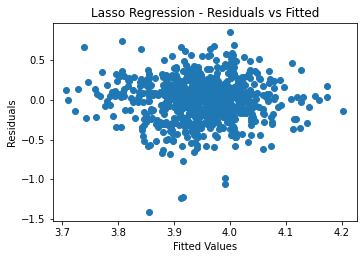

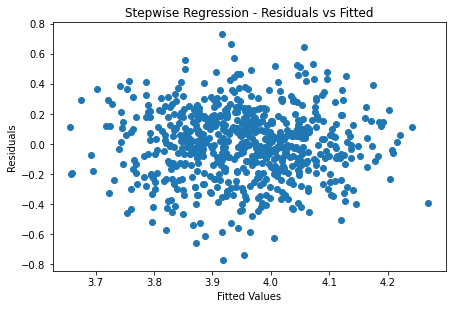

In [89]:
# Lasso regression
plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
plt.title("Lasso Regression - Residuals vs Fitted")
plt.scatter(lm_all.fittedvalues, lm_all.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")


# Stepwise regression
plt.figure(figsize=(12, 8))
plt.subplot(2,2,2)
plt.title("Stepwise Regression - Residuals vs Fitted")
plt.scatter(step_model.fittedvalues, step_model.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

'''
plt.subplot(2, 2, 3)
plt.title("Lasso Regression - Normal Q-Q Plot")
sm.qqplot(lm_all.resid, line='r')

plt.subplot(2, 2, 4)
plt.title("Stepwise Regression - Normal Q-Q Plot")
sm.qqplot(step_model.resid, line='r')
'''
plt.tight_layout()
plt.show()


We can see from the Residual vs Fitted plot that residuals are randomly scattered and centered around zero, it suggests that the variance of the residuals is roughly constant across all levels of the predicted values. The Stepwise Regression model is doing a more reasonable job of capturing the variation in the data than Lasso Regression.

Overall, we can conclude from this regression analysis that in London Santander Service Area. Increased distances to bus station and residential area within buffer area are associated with lower bike-sharing demand. Additionally, bike-sharing ridership is significantly higher among populations that have fewer employment deprived residents, and in areas with a higher proportion of cycling lanes. 

In [ ]:


# Perform stepwise regression removing outliers
outlier_indices = [10, 12, 13]
trips_removed_outliers = trips.drop(outlier_indices)
step_model_removed_outliers = ols('logcount ~ ST_DIST + DOWNTOWN_DIST + CYL_PER1 + employment + uni + population_density', data=trips_removed_outliers).fit().step(direction='both', verbose=0)
print(step_model_removed_outliers.summary())

Compare AIC values：比较Lasso回归模型和逐步回归模型的AIC值，AIC值越小越好，表示模型对数据的拟合越好。 comparing the AIC values of the Lasso regression model and the stepwise regression model, the smaller the AIC value, the better it indicates that the model fits the data better.

In [ ]:
'''
if lasso_aic < step_aic:
    print("Lasso Regression is preferred with AIC =", lasso_aic)
else:
    print("Stepwise Regression is preferred with AIC =", step_aic)
'''

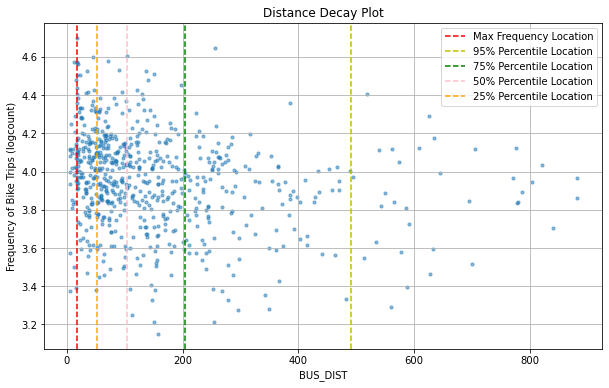

In [34]:


# Assuming you have a DataFrame 'trips1' with 'BUS_DIST' and 'logcount' columns
x = trips1['BUS_DIST']
y = trips1['logcount']

# Calculate the maximum frequency location
max_freq_location = x[y.idxmax()]

# Calculate the 75th percentile location
percentile_95_location = np.percentile(x, 95)
percentile_75_location = np.percentile(x, 75)
percentile_50_location = np.percentile(x, 50)
percentile_25_location = np.percentile(x, 25)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, s=10)
plt.axvline(x=max_freq_location, color='r', linestyle='--', label='Max Frequency Location')
plt.axvline(x=percentile_95_location, color='y', linestyle='--', label='95% Percentile Location')
plt.axvline(x=percentile_75_location, color='g', linestyle='--', label='75% Percentile Location')
plt.axvline(x=percentile_50_location, color='pink', linestyle='--', label='50% Percentile Location')
plt.axvline(x=percentile_25_location, color='orange', linestyle='--', label='25% Percentile Location')

plt.xlabel('BUS_DIST')
plt.ylabel('Frequency of Bike Trips (logcount)')
plt.title('Distance Decay Plot')
plt.grid(True)
plt.legend()
plt.show()


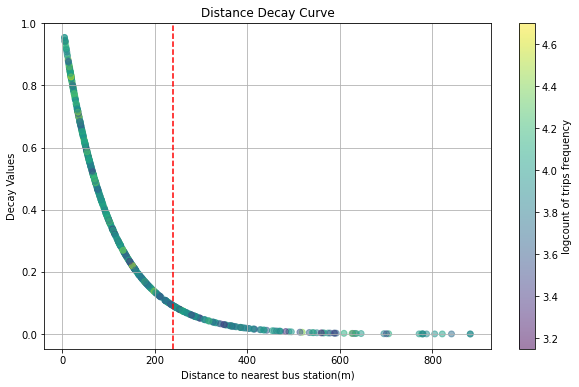

In [136]:

# 定义距离衰减函数
def distance_decay(distance, decay_rate):
    return np.exp(-decay_rate * distance)

# 从trips1数据集中获取BUS_DIST和logcount列
bus_dist = trips1['BUS_DIST']
logcount = trips1['logcount']

# 计算距离衰减曲线
decay_rate = 0.01  # 适当调整衰减率
decay_values = distance_decay(bus_dist, decay_rate)


# 绘制距离衰减曲线
plt.figure(figsize=(10, 6))
plt.scatter(bus_dist, decay_values, c=logcount, cmap='viridis', alpha=0.5)
plt.axvline(x=bus_dist[turning_points[0]], color='red', linestyle='--', label='Turning Point')
plt.xlabel('Distance to nearest bus station(m)')
plt.ylabel('Decay Values')
plt.title('Distance Decay Curve')
plt.colorbar(label='logcount of trips frequency')
plt.grid(True)

# 导出距离衰减曲线图，设置 dpi 参数以提高分辨率
plt.savefig('distance_decay_curve_BusStation.jpg', dpi=200)

# 显示图形
plt.show()


## TRY2 :Ramdom Forest Regressor

In [58]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [67]:
# create feature matrix X and target variable y
#selected=['BUS_DIST','ResCoverS','CarorVanCo', 'ResidentRatio', 'CommerRatio','ParkCoverS','RoadDen','POPDEN']
selected=['BUS_DIST', 'CAZ_DIST', 'RetailCoverS', 'ResCoverS', 'ParkCoverS', 'CommerCoverS', 'Deprivatio', 'RoadDen']
X = trips[selected]
y = trips['logcount']

#X = sm.add_constant(X)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# 创建决策树回归模型
regressor = DecisionTreeRegressor(random_state=42)

# 拟合模型
regressor.fit(X_train, y_train)

# 进行预测
y_pred = regressor.predict(X_test)


# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

# Print evaluation metrics with explanations
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 0.13737721871534825


In [68]:
# 假设 X 是自变量，y 是连续型目标变量 logcount
regressor = DecisionTreeRegressor(random_state=42)

# 拟合模型
regressor.fit(X, y)

# 获取特征重要性分数
feature_importance = regressor.feature_importances_

# 将特征重要性分数与对应的特征名字关联起来
feature_names = X.columns  # 假设你的自变量在一个DataFrame中
feature_importance_dict = dict(zip(feature_names, feature_importance))

# 将特征重要性评分表按分数从大到小排序
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# 打印排序后的特征重要性评分表
for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: CommerCoverS, Importance: 0.23652144323100752
Feature: BUS_DIST, Importance: 0.1676259609741178
Feature: CAZ_DIST, Importance: 0.13163232652835732
Feature: RoadDen, Importance: 0.10585821331898403
Feature: ParkCoverS, Importance: 0.10523610281102164
Feature: ResCoverS, Importance: 0.09968480886237562
Feature: Deprivatio, Importance: 0.08678810952866954
Feature: RetailCoverS, Importance: 0.06665303474546641


AttributeError: 'BarContainer' object has no attribute 'get_array'

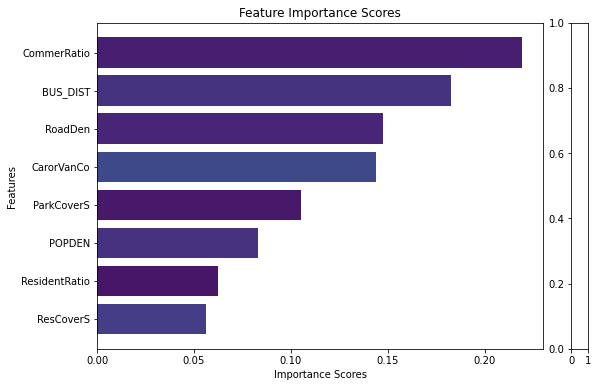

In [62]:
# 假设 X 是自变量，y 是连续型目标变量 logcount
regressor = DecisionTreeRegressor(random_state=42)

# 拟合模型
regressor.fit(X, y)

# 获取特征重要性分数
feature_importance = regressor.feature_importances_

# Associate feature importance scores with corresponding feature names
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort feature importance scores in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=False)

# Plot the horizontal bar chart with different colors
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(feature_importance)  # Use a colormap for colors

# Extract feature names and importance scores for plotting
features, importance_scores = zip(*sorted_feature_importance)

# Create a horizontal bar chart
bars = plt.barh(features, importance_scores, color=colors)

# Customize the plot
plt.title('Feature Importance Scores')
plt.xlabel('Importance Scores')
plt.ylabel('Features')

# Add a colorbar to indicate the importance values
cbar = plt.colorbar(bars)
cbar.set_label('Importance Values')

# Show the plot
plt.tight_layout()
plt.show()